In [48]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the feature vector
    return hist_features



def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features




def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image_read = mpimg.imread(file)
       

        image = image_read.astype(np.float32)
            
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



def train_classifier(cars,notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32):
    color_space = cspace # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    

    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial_size[0],
        'and', hist_bins,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc, X_scaler



In [49]:
# Main

cars = glob.glob("vehicles/**/*.png", recursive=True)
notcars = glob.glob("non-vehicles/**/*.png", recursive=True)

# Train my classifier
clf, scaler = train_classifier(cars,notcars, cspace='YCrCb', spatial_size=(8,8),
                        hist_bins=32)



Using spatial binning of: 8 and 32 histogram bins
Feature vector length: 5580
33.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


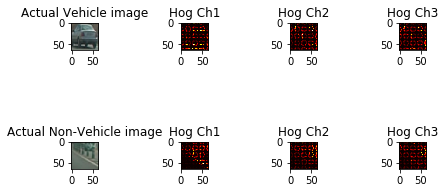

In [51]:
# Sandbox

def extract_features_single(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
       
        
        

        
        features = []
            
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                hog_image = [None]*3
                for channel in range(feature_image.shape[2]):
                    hog_features_ch, hog_image[channel] = get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
                    hog_features.append(hog_features_ch)
                hog_features = np.ravel(hog_features)        
            else:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)
        
       
        # Return list of feature vectors
        return np.concatenate(features), hog_image



color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (8,8) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off   

vehicle_test_file = "vehicles/GTI_Right/image0038.png"
veh_image_read = mpimg.imread(vehicle_test_file)
test_features, hog_image_veh = extract_features_single(veh_image_read, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

nonveh_test_file = "non-vehicles/GTI/image5.png"
nonveh_image_read = mpimg.imread(nonveh_test_file)
test_features, hog_image_nonveh = extract_features_single(nonveh_image_read, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#X_test = scaler.transform(np.array(test_features).reshape(1, -1))
#print("Prediction = ", clf.predict(X_test))
#print(test_features)
mpimg.imsave("./output_images/Vehicle_ch1.png",hog_image_veh[0])
mpimg.imsave("./output_images/Vehicle_ch2.png",hog_image_veh[1])
mpimg.imsave("./output_images/Vehicle_ch3.png",hog_image_veh[2])
mpimg.imsave("./output_images/Non-Vehicle_ch1.png",hog_image_nonveh[0])
mpimg.imsave("./output_images/Non-Vehicle_ch2.png",hog_image_nonveh[1])
mpimg.imsave("./output_images/Non-Vehicle_ch3.png",hog_image_nonveh[2])
fig = plt.figure()
plt.subplot(241)
plt.imshow(veh_image_read)
plt.title('Actual Vehicle image')
plt.subplot(242)
plt.imshow(hog_image_veh[0], cmap='hot')
plt.title('Hog Ch1')

plt.subplot(243)
plt.imshow(hog_image_veh[1], cmap='hot')
plt.title('Hog Ch2')

plt.subplot(244)
plt.imshow(hog_image_veh[2], cmap='hot')
plt.title('Hog Ch3')
fig.tight_layout()


plt.subplot(245)
plt.imshow(nonveh_image_read)
plt.title('Actual Non-Vehicle image')
plt.subplot(246)
plt.imshow(hog_image_nonveh[0], cmap='hot')
plt.title('Hog Ch1')

plt.subplot(247)
plt.imshow(hog_image_nonveh[1], cmap='hot')
plt.title('Hog Ch2')

plt.subplot(248)
plt.imshow(hog_image_nonveh[2], cmap='hot')
plt.title('Hog Ch3')
fig.tight_layout()



Time taken:  2.37


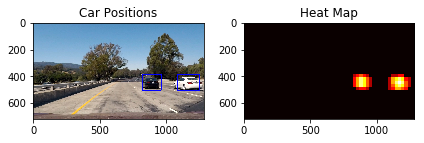

In [62]:
# Define a single function that does a sliding window search
import os
%matplotlib inline
from scipy.ndimage.measurements import label

# Function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Returns a list of windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []
    X_start = x_start_stop[0] if (x_start_stop[0] != None) else 0
    X_stop =  x_start_stop[1] if (x_start_stop[1] != None) else img.shape[1]
   
    
    Y_start = y_start_stop[0] if (y_start_stop[0] != None) else 0
    Y_stop =  y_start_stop[1] if (y_start_stop[1] != None) else img.shape[0]

    x_stride = np.int(xy_window[0]*(1-xy_overlap[0]))
    y_stride = np.int(xy_window[1]*(1-xy_overlap[1]))
 
    x_windows = np.int(((X_stop-X_start)/x_stride) - 1)
    y_windows = np.int(((Y_stop-Y_start)/y_stride) - 1)
    total_windows = x_windows*y_windows

    # Loop through finding x and y window positions
    for y_w in range(y_windows):
        for x_w in range(x_windows):
            top_left_x = max(0,x_w*x_stride + X_start)
            bottom_right_x = min(top_left_x + xy_window[0], img.shape[1])
            top_left_y = max(0,y_w*y_stride + Y_start)
            bottom_right_y = min(top_left_y + xy_window[1], img.shape[0])
            top_left = (top_left_x, top_left_y)
            bottom_right = (bottom_right_x,bottom_right_y)
            window_list.append((top_left, bottom_right))
    
    # Return the list of windows
    return window_list


def extract_features_img(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
       
        
        
        
        
        features = []
            
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)
        
       
        # Return list of feature vectors
        return np.concatenate(features)
    
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    img_scaled = img.astype(np.float32)/255
    
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img_scaled[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        
        #4) Extract features for that window using single_img_features()
        features = extract_features_single(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
       
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars1(img, ystart, ystop, scale, svc, X_scaler,color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            features.append(spatial_features)
            features.append(hist_features)
            features.append(hog_feat1)
            features.append(hog_feat2)
            features.append(hog_feat3)
            
            features_concat = np.concatenate(features)
            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features = X_scaler.transform(np.array(features_concat).reshape(1, -1))
              
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, box_list



cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (8,8) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off   

test_img = mpimg.imread("test_images/test1.jpg")
t = time.time()
#windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[np.int(test_img.shape[0]*0.50), None], 
#                   xy_window=(96,96), xy_overlap=(0.75, 0.75))


#box_list = search_windows(test_img, windows, clf, scaler, color_space=cspace, 
#                        spatial_size=spatial_size, hist_bins=hist_bins, 
#                        orient=orient, pix_per_cell=pix_per_cell, 
#                        cell_per_block=cell_per_block, 
#                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                        hist_feat=hist_feat, hog_feat=hog_feat)

#out_img = find_cars(test_img, windows, 1, clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img, box_list = find_cars1(test_img, int(test_img.shape[0]*0.50), test_img.shape[0], 1.5, clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

draw_image_1 = np.copy(test_img)
raw_window_img = draw_boxes(draw_image_1, box_list, color=(0, 0, 255), thick=6)                    

mpimg.imsave("./output_images/test1_sliding_windows.jpg", raw_window_img)
mpimg.imsave("./output_images/test1_output_boxes.jpg", draw_img)
mpimg.imsave("./output_images/test1_heatmap.jpg", heatmap, cmap='hot')
t2 = time.time()


fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

print("Time taken: ", round(t2-t,2))

Opening file calibration1.jpg
(720, 1280, 3)
Opening file calibration10.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration11.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration12.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration13.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration14.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration15.jpg
(721, 1281, 3)
Debug: Found corners
Opening file calibration16.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration17.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration18.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration19.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration2.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration20.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration3.jpg
(720, 1280, 3)
Debug: Found corners
Opening file calibration4.jpg
(720, 1280, 3)
Opening file calibration5.jpg
(720, 1280,

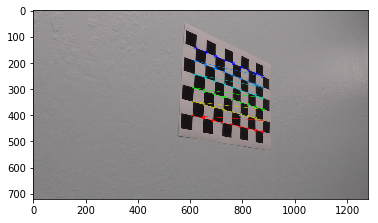

In [53]:
# prepare object points
nx = 9
ny = 6


objpoints = [] # 3D points in the real world
imgpoints = [] # 2D points in the image plane

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

class calibration_mat:
    def __init__(self,ret,mtx,dist,rvecs,tvecs):
        self.ret = ret
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs
        
cal_folder = "./camera_cal"

for cal_file in os.listdir(cal_folder):
    img = cv2.imread(cal_folder + "/" + cal_file)
    print ("Opening file", cal_file)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print (img.shape)

    if ret == True:
        print ("Debug: Found corners")
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        imgpoints.append(corners)
        objpoints.append(objp)
    
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
cal_mat = calibration_mat(ret,mtx,dist,rvecs,tvecs)
dst = cv2.undistort(img, cal_mat.mtx, cal_mat.dist, None, cal_mat.mtx)
plt.imshow(dst)
for cal_file in os.listdir(cal_folder):
    img = cv2.imread(cal_folder + "/" + cal_file)
    undist = cv2.undistort(img, cal_mat.mtx, cal_mat.dist, None, cal_mat.mtx)
    cv2.imwrite("output_images/"+"undist_"+cal_file, undist)

In [54]:
verbose = 0
import math
class thresholds_cls:
    def __init__(self):
        self.thrsh_max = 255 #thrsh_max
        self.thrsh_min = 180 #thrsh_min
        

        
class window_search:
    def __init__(self):
        self.window_width = 50
        self.window_height = 80
        self.search_margin = 100
        self.recent_centers = []

        
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def correct_distortion(img):
    return cv2.undistort(img, cal_mat.mtx, cal_mat.dist, None, cal_mat.mtx)

def color_thresh(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    
    
    # Threshold color channel
    s_thresh_min = color_thresholds.thrsh_min
    s_thresh_max = color_thresholds.thrsh_max
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    
    hsv= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    # Threshold color channel
    v_thresh_min = color_thresholds.thrsh_min
    v_thresh_max = color_thresholds.thrsh_max
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh_min) & (v_channel <= v_thresh_max)] = 1
    if (verbose > 2): print("Debug: Color thrsh (min,max) : ",s_thresh_min, s_thresh_max )
        
    output = np.zeros_like(s_binary)
    output[(s_binary == 1)& (v_binary==1)] = 1
    return output


def grad_abs_thrsh(img,sobel_kernel=3,direction='x',thresh=(100,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Sobel filtering
    if (direction == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    elif (direction == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    else:
        print ("Error using grad_abs_thrsh: Direction can only be 'x' or 'y'")
        sys.exit(1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    if (verbose > 2): print("Debug: Grad Mag thrsh (min,max) : ",thresh[0], thresh[1] )
    
    return s_binary
    
def grad_dir_thrsh(img,sobel_kernel=3,thresh=(0,np.pi/2)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan_sobelxy = np.absolute(np.arctan2(abs_sobely, abs_sobelx))
    
    scale_bin = np.zeros_like(arctan_sobelxy)
    scale_bin[(arctan_sobelxy>=thresh[0]) & (arctan_sobelxy<thresh[1])] = 1
    if (verbose > 2): print("Debug: Grad Dir thrsh (min,max) : ",thresh[0], thresh[1] )
    return scale_bin

def grad_mag_thrsh(img,sobel_kernel=3,thresh=(100,255)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Sobel filtering
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelxy = np.sqrt(np.square(np.absolute(sobelx)) + np.square(np.absolute(sobely))) 
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    s_binary = np.zeros_like(scaled_sobelxy)
    s_binary[(scaled_sobelxy >= thresh[0]) & (scaled_sobelxy <= thresh[1])] = 1
    if (verbose > 2): print("Debug: Grad Mag thrsh (min,max) : ",thresh[0], thresh[1] )
    
    return s_binary
# Combine magnitude threshold and direction threshold
def grad_thresh(img):
    
    mag_thresh_min = mag_grad_thresholds.thrsh_min
    mag_thresh_max = mag_grad_thresholds.thrsh_max
    dir_thresh_min = dir_grad_thresholds.thrsh_min
    dir_thresh_max = dir_grad_thresholds.thrsh_max
    absX_thresh_min = absX_grad_thresholds.thrsh_min
    absX_thresh_max = absX_grad_thresholds.thrsh_max
    absY_thresh_min = absY_grad_thresholds.thrsh_min
    absY_thresh_max = absY_grad_thresholds.thrsh_max
    sobel_kernel = 3
    
    mag_binary = grad_mag_thrsh(img,sobel_kernel,(mag_thresh_min,mag_thresh_max))
    dir_binary = grad_dir_thrsh(img,sobel_kernel,(dir_thresh_min,dir_thresh_max))
    absX_binary = grad_abs_thrsh(img,sobel_kernel,'x',(absX_thresh_min,absX_thresh_max))
    absY_binary = grad_abs_thrsh(img,sobel_kernel,'y',(absY_thresh_min,absY_thresh_max))
    if (verbose > 2): print("Debug Mag binary = ",mag_binary)
    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1) & (absX_binary == 1) & (absY_binary == 1))] = 1
    return combined
    
def color_n_grad_thresh(img):
    color_thrsh_binary = color_thresh(img)
    grad_thrsh_binary = grad_thresh(img)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_thrsh_binary)
    combined_binary[(color_thrsh_binary == 1) | (grad_thrsh_binary == 1)] = 255

    
    image = combined_binary
    return image

# Returns src and dst points for perspective transform 
def perspective_points(img):
    img_size = (img.shape[1],img.shape[0])
    
    app_lane_center = ((img_size[0]/2),img_size[1]) # This is the expected center of the lane i.e. center of the trapezium
    height_cent = 0.25 # Height of the trapezium  as % of image Y
    bott_cent = 1.0 #0.80 # Bottom width as a % of image X
    top_cent = 0.41#0.32 # Top width as a % of image X
    
    top_width = top_cent*img_size[0]
    hgt = height_cent*img_size[1]
    bottom_width = bott_cent*img_size[0]
    coord_TL = [app_lane_center[0] - (top_width/2),img_size[1]-hgt]
    coord_TR = [app_lane_center[0] + (top_width/2),img_size[1]-hgt]
    coord_BL = [app_lane_center[0] - (bottom_width/2),img_size[1]]
    coord_BR = [app_lane_center[0] + (bottom_width/2),img_size[1]]
    
    # Coordinates of the desired rectangle
    dst_TL = [coord_BL[0],coord_TL[1]]
    dst_TR = [coord_BR[0],coord_TR[1]]
    dst_BL = coord_BL
    dst_BR = coord_BR
    
    src = np.float32([coord_TL,coord_TR,coord_BL,coord_BR])
    dst = np.float32([dst_TL,dst_TR,dst_BL,dst_BR])
    
    return src,dst

def get_window_centroids(img):
    window_centroids = []
    w_width = window_search_params.window_width
    w_hgt = window_search_params.window_height
    window = np.ones(w_width)
    search_margin = window_search_params.search_margin
    
    x_mid = int(img.shape[1]/2)
    lft_hist = np.sum(img[int(0.75*img.shape[0]):,:x_mid],axis=0)
    lft_center = np.argmax(np.convolve(window,lft_hist)) - int(w_width/2)
    rgt_hist = np.sum(img[int(0.75*img.shape[0]):,x_mid:],axis=0)
    rgt_center = np.argmax(np.convolve(window,rgt_hist)) - int(w_width/2) + x_mid
    
    
    leftx = []
    rightx = []
    yval = []
    #Save the starting indices for left and right lanes
    window_centroids.append((lft_center,rgt_center))
    leftx.append(lft_center)
    rightx.append(rgt_center)
    yval.append(img.shape[0]-int(w_hgt/2))
    expected_lane_width = rgt_center - lft_center
    for level in range(1,int(img.shape[0]/w_hgt)):
        window_low = int(img.shape[0] - (level*w_hgt))
        window_high = int(img.shape[0] - ((level+1)*w_hgt))
        hist_layer = np.sum(img[window_high:window_low,:],axis=0)
        conv = np.convolve(window,hist_layer)
        found_lft_lane = 0
        found_rgt_lane = 0
        # Look at the previous centroid and look around that range in hist_layer
        
        l_min = int(max(lft_center+int(w_width/2) - search_margin,0))
        l_max = int(min(lft_center+int(w_width/2) + search_margin,img.shape[1]))
        if (np.max(conv[l_min:l_max]) > 0):
            found_lft_lane = 1
            lft_center = (np.argmax(conv[l_min:l_max]) - int(w_width/2) + l_min)
        if (np.max(conv[l_min:l_max]) == 0):
            found_lft_lane = 1
            lft_center = rgt_center - expected_lane_width
        
        
        r_min = int(max(rgt_center+int(w_width/2) - search_margin,0))
        r_max = int(min(rgt_center+int(w_width/2) + search_margin,img.shape[1]))
        
        if (np.max(conv[r_min:r_max]) > 0):
            found_rgt_lane = 1
            rgt_center = np.argmax(conv[r_min:r_max]) - int(w_width/2) + r_min
        if (np.max(conv[r_min:r_max]) == 0):
            found_rgt_lane = 1
            rgt_center = expected_lane_width + lft_center
            
        if ((found_lft_lane & found_rgt_lane)):
            window_centroids.append((lft_center,rgt_center))
            leftx.append(lft_center)
            rightx.append(rgt_center)
            yval.append(window_low-int(w_hgt/2))

    window_search_params.recent_centers.append(window_centroids)
    window_centroids_avg = np.average(window_search_params.recent_centers[-15:],axis=0)
    return window_centroids_avg, leftx, rightx, yval

def draw_window_centroids(warped,window_centroids):

    window_width = window_search_params.window_width
    window_height = window_search_params.window_height
# If we found any window centers
    if len(window_centroids) > 0:

        #     Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    return output

def draw_lane_plot(undist, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

#Lane finding pipeline. 
def find_lane(img):
    # Undistort each frame
    undist = correct_distortion(img)
    # Threshold based on color and gradient
    binary_image = color_n_grad_thresh(undist)
    # Perspective transform
    src,dst = perspective_points(binary_image)
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(binary_image,M,(binary_image.shape[1],binary_image.shape[0]),flags=cv2.INTER_LINEAR)
    
    #Find lane centers
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    window_centroids, leftx, rightx, ploty = get_window_centroids(warped)
    # Visualize lane centers
    warped_debug = draw_window_centroids(warped,window_centroids)
    
    # Fit to find the lane boundary
    if (len(window_centroids) > 0):
        
        ploty = np.array(ploty)
        y_range = np.arange(warped.shape[0]-int(window_search_params.window_height/2),int(window_search_params.window_height/2), -window_search_params.window_height)
    
        #print ("Debug: Lane center = ", lane_center)
        #print ("Debug: Lane Departure = ", departure_frm_ctr)
        act_lane_width = 3.7 # 3.7 m
        act_lane_len = 30 # 30 m
        x_m_per_pixel = act_lane_width/np.absolute(leftx[0]-rightx[0])
        y_m_per_pixel = act_lane_len/np.absolute(y_range[0]-y_range[-1])
    
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = (left_fit[0]*y_range*y_range) + (left_fit[1]*y_range) + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = (right_fit[0]*y_range*y_range) + (right_fit[1]*y_range) + right_fit[2]
    

        left_fit_cr = np.polyfit(np.array(ploty,np.float32)*y_m_per_pixel, np.array(leftx,np.float32)*x_m_per_pixel, 2)
        right_fit_cr = np.polyfit(np.array(ploty,np.float32)*y_m_per_pixel, np.array(rightx,np.float32)*x_m_per_pixel, 2)
        # Calculate the radii of curvature
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*y_m_per_pixel + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*y_m_per_pixel + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        lane_center = (leftx[0] + rightx[0])/2
        departure_frm_ctr = lane_center - (img.shape[1]/2) # Lane departure in 
        lane_position = 'left' if (departure_frm_ctr >= 0) else 'right'
        departure_frm_ctr_m = departure_frm_ctr*x_m_per_pixel
        if(math.isnan(left_curverad)):
            test_im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            cv2.imwrite('testframe.jpg',test_im)
        
    
        # Draw the lane on the warped image
        img_result = draw_lane_plot(undist, warped, Minv, left_fitx, right_fitx, y_range)
        cv2.putText(img_result, 'Radius of curvature = ' + str(left_curverad) + 'm', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
        cv2.putText(img_result, 'Vehicle is ' + str(abs(departure_frm_ctr_m)) + 'm ' + lane_position+' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    else:
        img_result = undist
    

    return binary_image, warped, warped_debug, histogram, img_result, left_curverad, right_curverad


In [56]:
#Import everything needed to edit/save/watch video clips\n",
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class Vehicle:
    def __init__(self):
        self.boxlist = []
        self.box_width = 0
        self.centroids = []
def detect_cars(img_rgb):
    cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (8,8) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off   
    scale = 1.5

    #windows = slide_window(img_rgb, x_start_stop=[None, None], y_start_stop=[np.int(test_img.shape[0]*0.50), None], 
    #               xy_window=(96,96), xy_overlap=(0.75, 0.75))


    #box_list = search_windows(img_rgb, windows, clf, scaler, color_space=cspace, 
    #                    spatial_size=spatial_size, hist_bins=hist_bins, 
    #                    orient=orient, pix_per_cell=pix_per_cell, 
    #                    cell_per_block=cell_per_block, 
    #                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
    #                    hist_feat=hist_feat, hog_feat=hog_feat)

    binary_image, top_down, warped_debug, histogram, final_image, left_curvature, right_curvature = find_lane(img_rgb)
    out_img, box_list = find_cars1(final_image, int(final_image.shape[0]*0.50), final_image.shape[0], scale, clf, scaler, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(final_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(final_image), labels)

    return draw_img


# Instantiate reqd objects
color_thresholds = thresholds_cls()
mag_grad_thresholds = thresholds_cls()
dir_grad_thresholds = thresholds_cls()
absX_grad_thresholds = thresholds_cls()
absY_grad_thresholds = thresholds_cls()
window_search_params = window_search()
        
# Set parameter values
mag_grad_thresholds.thrsh_min = 50
mag_grad_thresholds.thrsh_max = 255
dir_grad_thresholds.thrsh_min = 0.9
dir_grad_thresholds.thrsh_max = 1.2
absX_grad_thresholds.thrsh_min = 12
absX_grad_thresholds.thrsh_max = 255
absY_grad_thresholds.thrsh_min = 25
absY_grad_thresholds.thrsh_max = 255
color_thresholds.thrsh_min = 100
color_thresholds.thrsh_max = 255
window_search_params.window_width = 50
window_search_params.window_height = 80
window_search_params.search_margin = 100   
pipeline_output = 'project_video_veh_detect.mp4'
clip1 = VideoFileClip("project_video.mp4")
    
veh_find_fn = clip1.fl_image(detect_cars)
%time veh_find_fn.write_videofile(pipeline_output, audio=False)


[MoviePy] >>>> Building video project_video_veh_detect.mp4
[MoviePy] Writing video project_video_veh_detect.mp4


100%|█████████▉| 1260/1261 [17:23<00:00,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_veh_detect.mp4 

CPU times: user 16min 42s, sys: 1min 43s, total: 18min 26s
Wall time: 17min 25s
